# Assignment 1 - Blending

Name: Nalet Meinen<br>
Matriculation number: 13-463-955

In [1]:
from numpy import *
from PIL import Image
import matplotlib.pyplot as plt
from skimage.transform import resize
from scipy import sparse
from scipy.signal import convolve2d
from hessian_matrix import hessian_matrix

Text(0.5, 1.0, 'Foreground')

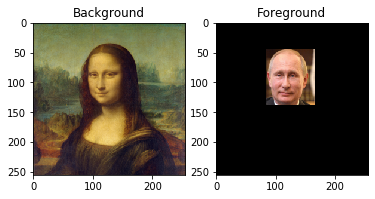

In [2]:
b = array(Image.open('monalisa.png')) / 256
f = array(Image.open('putin.jpg')) / 256

# head location of Mona and Putin
m = [83, 45, 166, 139]
p = [285, 1, 585, 307]

# align foreground
f2 = zeros((256, 256, 3))
tmp = resize(f[p[1]:p[3], p[0]:p[2], :], (m[3] - m[1], m[2] - m[0]))
f2[m[1]:m[3], m[0]:m[2], :] = tmp

plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(b)
plt.title('Background')
plt.subplot(1, 2, 2)
plt.imshow(f2)
plt.title('Foreground')

Text(0.5, 1.0, 'Mask')

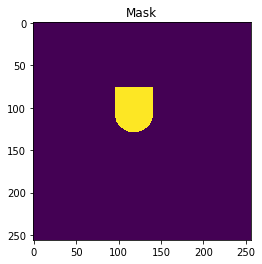

In [3]:
# apply mask
c = [118, 106]
r = 23
bb = [96, 76, 141, 109]
x, y = meshgrid(arange(256), arange(256))
omega = ((x - c[0]) ** 2 + (y - c[1]) ** 2) < r ** 2      
omega[bb[1]:bb[3], bb[0]:bb[2]] = True

plt.figure()
plt.imshow(omega)
plt.title('Mask')

## (a) Gradient Descent

In [4]:
def GD_E(u, b, f, omega, lmbda):

    m,n,l = shape(b)
    grad = zeros((m,n,l))
    kernel = array([[0,-1,0], [-1,4,-1], [0,-1,0]])#  values of the coefficients from the derivative calculation

    for k in arange(0,l):
        grad[:,:,k] = 2 * (1-omega) * (u[:,:,k]-b[:,:,k]) + 2 * lmbda * omega * (convolve2d(u[:,:,k],kernel,'same')-convolve2d(f[:,:,k],kernel,'same'))
    
    return grad


def GD(f, b, omega, lmbda):
    """
    b: backgound color image of size (M, N, 3)
    f: foreground color image of size (M, N, 3)
    omega: foreground mask of size (M, N)
    lmbda: parameter

    :returns u: blended image of size (M, N, 3)
    """
    
    m,n,l = shape(b)
    u = b.copy()

    eps = 0.05 # step size
    err_E = iinfo(int32).max # error which determines when to stop
    grad_E = zeros((m,n,l))
    #E = []; # value of the energy function
    
    
    

    while err_E > 0.01: # until the gradient is close enough to zero
        grad_E = GD_E(u, b, f, omega, lmbda)

        err_E = max(grad_E.flatten('F'))
        #E = [E; E_AB(u, b, f, omega, lambda)]

        for k in arange(0,l):
            u[:,:,k] = u[:,:,k] - eps * grad_E[:,:,k]

    clip(u,0,255,u)
    
    return u #return b

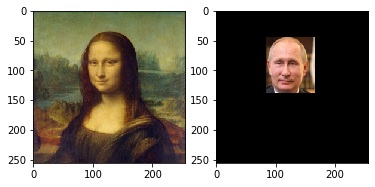

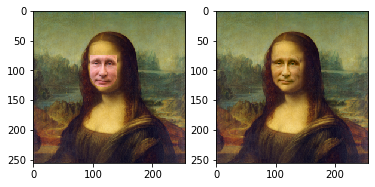

In [5]:
# blend
lmbda = 2  # change
u = GD(f2, b, omega, lmbda)

# display
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(b)
plt.subplot(1, 2, 2)
plt.imshow(f2)

plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(expand_dims(omega, 2) * f2 + expand_dims(1 - omega, 2) * b)
plt.subplot(1, 2, 2)
plt.imshow(u)

## (b) Linearization + Gauss-Seidel

In [6]:
def gauss_seidel(A, b):
    x = zeros((n, 1))
    return x

In [7]:
def LGS(f, b, omega, lmbda):
    """          
    b: backgound color image of size (M, N, 3)
    f: foreground color image of size (M, N, 3)
    omega: foreground mask of size (M, N)
    lmbda: parameter

    :returns u: blended image of size (M, N, 3)
    """
    
    u = b.copy()
    m,n,l = shape(b)
    A = zeros((m,n,l))
    coeff1 = array([2,0,0,0,0]) # coefficients of the hessian for the background part
    coeff2 = array([8,-2,-2,-2,-2]) # coefficients of the hessian for the foreground part
    n_iterations = 10 #90;
    #E = []; % value of the energy function

    for s in arange(0,n_iterations):
        #E = [E; E_AB(u, b, f, omega, lambda)];

        for i in arange(0,l):
            t = u[:,:,i] # extract the color channel

            background = (1-omega) * reshape(hessian_matrix(t,coeff1,lmbda)*t.flatten('F'), (m,n), order='F') # reshape directly the H*u calculation 
            foreground = lmbda * omega * reshape(hessian_matrix(t,coeff2,lmbda)*t.flatten('F'), (m,n), order='F') # reshape directly the H*u calculation
            A[:,:,i] = background + foreground;  
        

        grad_E = GD_E(u, b, f, omega, lmbda)

        # Gauss seidel algorithm for each color channel
        for i in arange(0,l):
            c = A[:,:,i]*u[:,:,i] - grad_E[:,:,i]
            L = tril(A[:,:,i])
            U = triu(A[:,:,i], 1)
            u[:,:,i] = linalg.solve(L,(c-U*u[:,:,i]))
    
    return u #return b

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: overflow encountered in multiply
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: overflow encountered in multiply
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in subtract
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in multiply
  


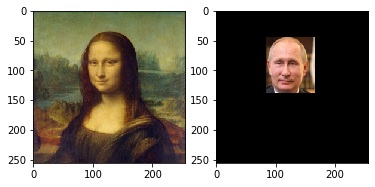

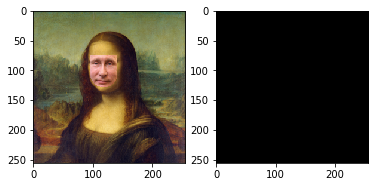

In [8]:
# blend
lmbda = 5  # change 
u = LGS(f2, b, omega, lmbda)

# display
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(b)
plt.subplot(1, 2, 2)
plt.imshow(f2)

plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(expand_dims(omega, 2) * f2 + expand_dims(1 - omega, 2) * b)
plt.subplot(1, 2, 2)
plt.imshow(u)

## (c) Linearization + SOR

In [9]:
def LSOR(f, b, omega, lmbda):
    """         
    b: backgound color image of size (M, N, 3)
    f: foreground color image of size (M, N, 3)
    omega: foreground mask of size (M, N)
    lmbda: parameter

    :returns u: blended image of size (M, N, 3)
    """
    
    u = b
    w = 1
    m,n,l = shape(b)
    A = zeros((m,n,l))
    coeff1 = array([2,0,0,0,0]) # coefficients of the hessian for the background part
    coeff2 = array([8,-2,-2,-2,-2]) # coefficients of the hessian for the foreground part
    c = zeros((m,n,l))
    n_iterations = 10;
    E = []# value of the energy function

    for s in arange(0,n_iterations):
        grad_E = GD_E(u, b, f, omega, lmbda);
        #E = [E; E_AB(u, b, f, omega, lmbda)];

        for i in arange(0,l):
            t = u[:,:,i] # extract the color channel
            background = (1-omega) * reshape(hessian_matrix(t,coeff1,lmbda) * t.flatten('F'), (m,n), order='F') # reshape directly the H*u calculation
            foreground = omega*reshape(hessian_matrix(t,coeff2,lmbda) * t.flatten('F'), (m,n), order='F') # reshape directly the H*u calculation
            A[:,:,i] = background + lmbda * foreground
            c[:,:,i] = A[:,:,i] * u[:,:,i] - grad_E[:,:,i];
        

        # Successive over relaxations algorithm for each color channel
        for i in arange(0,l):
            L = tril(A[:,:,i], -1);
            U = triu(A[:,:,i], 1);
            d = diag(A[:,:,i]);
            D = diag(d);
            u[:,:,i] = linalg.solve((D+w*L),(w*c[:,:,i]-(w*U + (w-1)*D)*u[:,:,i]))
    
    return u #return b

In [10]:
# blend
lmbda = 2  # change 
u = LSOR(f2, b, omega, lmbda)

# display
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(b)
plt.subplot(1, 2, 2)
plt.imshow(f2)

plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(expand_dims(omega, 2) * f2 + expand_dims(1 - omega, 2) * b)
plt.subplot(1, 2, 2)
plt.imshow(u)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in subtract
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in multiply
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: overflow encountered in multiply
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in multiply
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in multiply
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in subtract
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in multiply


KeyboardInterrupt: 